Model 1, with optimised parameters 

In this experiment the we optimized the learning rate with 0.01, weight decay as 0.00001, optimizer as SGD with a residual network which consists of 4 layers with 1,2,2,3 residual blocks respectively.

Model 3

In this experiment the we optimized the learning rate with 0.001, optimizer as Adam with a residual network which consists of 4 layers with 1,2,2,3 residual blocks respectively.

In this notebook we compare the best model versions of 2 different optimizers.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linearh = nn.Linear(256*block.expansion, 512)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = self.layer5(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = F.relu(self.linearh(out))
        out = self.linear(out)
        return out


def ResNet18_reduced_param():
    return ResNet(BasicBlock, [1, 2, 2, 3])

In [3]:
model = ResNet18_reduced_param()
sum = 0
for p in model.parameters():
    sum += p.numel()
print(sum)

4093866


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
net = ResNet18_reduced_param()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [8]:
trainacc = []
trainloss = []
testacc = []
testloss = []

In [9]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    trainacc.append(100.*correct/total)
    trainloss.append(train_loss/(batch_idx+1))
    print('Train Loss: %.3f | Acc: %.3f%% (%d/%d)'
           % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    testacc.append(100.*correct/total)
    testloss.append(test_loss/(batch_idx+1))
    print('Test Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [10]:
for epoch in range(start_epoch, start_epoch+100):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
Train Loss: 1.482 | Acc: 45.426% (22713/50000)
Test Loss: 1.102 | Acc: 60.060% (6006/10000)
Saving..

Epoch: 1
Train Loss: 1.000 | Acc: 64.636% (32318/50000)
Test Loss: 0.869 | Acc: 69.230% (6923/10000)
Saving..

Epoch: 2
Train Loss: 0.792 | Acc: 72.604% (36302/50000)
Test Loss: 0.802 | Acc: 71.800% (7180/10000)
Saving..

Epoch: 3
Train Loss: 0.688 | Acc: 76.352% (38176/50000)
Test Loss: 0.669 | Acc: 76.690% (7669/10000)
Saving..

Epoch: 4
Train Loss: 0.604 | Acc: 79.074% (39537/50000)
Test Loss: 0.567 | Acc: 80.870% (8087/10000)
Saving..

Epoch: 5
Train Loss: 0.547 | Acc: 81.246% (40623/50000)
Test Loss: 0.545 | Acc: 81.570% (8157/10000)
Saving..

Epoch: 6
Train Loss: 0.503 | Acc: 82.848% (41424/50000)
Test Loss: 0.517 | Acc: 82.800% (8280/10000)
Saving..

Epoch: 7
Train Loss: 0.465 | Acc: 84.134% (42067/50000)
Test Loss: 0.496 | Acc: 83.370% (8337/10000)
Saving..

Epoch: 8
Train Loss: 0.431 | Acc: 85.252% (42626/50000)
Test Loss: 0.568 | Acc: 81.940% (8194/10000)

Epoch: 9


In [15]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
optimizer = optim.Adam(net.parameters(), lr=0.01)
trainacc_adam = []
trainloss_adam = []
testacc_adam = []
testloss_adam = []

net_adam = ResNet18_reduced_param()
net_adam = net_adam.to(device)
if device == 'cuda':
    net_adam = torch.nn.DataParallel(net)
    cudnn.benchmark = True

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net_adam.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net_adam(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    trainacc_adam.append(100.*correct/total)
    trainloss_adam.append(train_loss/(batch_idx+1))
    print('Train Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net_adam.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net_adam(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    testacc_adam.append(100.*correct/total)
    testloss_adam.append(test_loss/(batch_idx+1))
    print('Test Loss: %.3f | Acc: %.3f%% (%d/%d)'
          % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc


for epoch in range(start_epoch, start_epoch+100):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
Train Loss: 1.597 | Acc: 43.542% (21771/50000)
Test Loss: 1.240 | Acc: 54.090% (5409/10000)
Saving..

Epoch: 1
Train Loss: 1.033 | Acc: 62.954% (31477/50000)
Test Loss: 0.938 | Acc: 67.210% (6721/10000)
Saving..

Epoch: 2
Train Loss: 0.818 | Acc: 71.436% (35718/50000)
Test Loss: 1.187 | Acc: 68.290% (6829/10000)
Saving..

Epoch: 3
Train Loss: 0.705 | Acc: 75.842% (37921/50000)
Test Loss: 0.830 | Acc: 73.110% (7311/10000)
Saving..

Epoch: 4
Train Loss: 0.639 | Acc: 78.086% (39043/50000)
Test Loss: 0.672 | Acc: 77.630% (7763/10000)
Saving..

Epoch: 5
Train Loss: 0.565 | Acc: 80.768% (40384/50000)
Test Loss: 0.523 | Acc: 82.320% (8232/10000)
Saving..

Epoch: 6
Train Loss: 0.528 | Acc: 82.094% (41047/50000)
Test Loss: 0.559 | Acc: 81.330% (8133/10000)

Epoch: 7
Train Loss: 0.490 | Acc: 83.298% (41649/50000)
Test Loss: 0.510 | Acc: 82.950% (8295/10000)
Saving..

Epoch: 8
Train Loss: 0.466 | Acc: 84.234% (42117/50000)
Test Loss: 0.558 | Acc: 81.980% (8198/10000)

Epoch: 9
Train Los

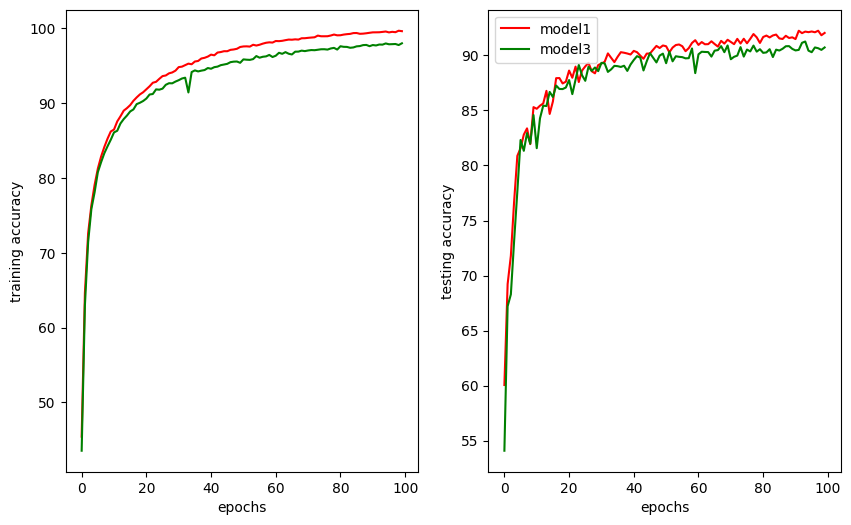

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(0, 100), trainacc, color='r', label='model1')
plt.plot(range(0, 100), trainacc_adam, color='g', label='model3')
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.subplot(1, 2, 2)
plt.plot(range(0, 100), testacc, color='r', label='model1')
plt.plot(range(0, 100), testacc_adam, color='g', label='model3')
plt.ylabel('testing accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

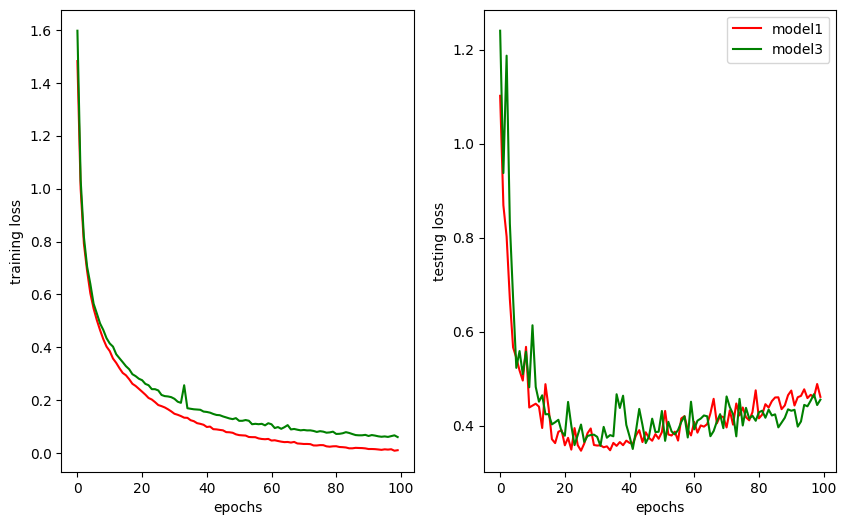

In [40]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(range(0, 100), trainloss, color='r', label='model1')
plt.plot(range(0, 100), trainloss_adam, color='g', label='model3')
plt.ylabel('training loss')
plt.xlabel('epochs')
plt.subplot(1, 2, 2)
plt.plot(range(0, 100), testloss, color='r', label='model1')
plt.plot(range(0, 100), testloss_adam, color='g', label='model3')
plt.ylabel('testing loss')
plt.xlabel('epochs')
plt.legend()
plt.show()